In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import img_to_array
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import imageio.v3 as imageio

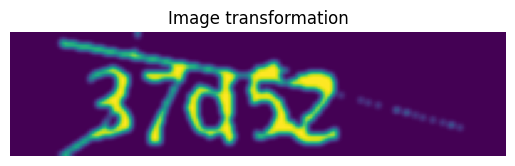

Processed 4850 segments.
Shape of X: (4850, 40, 20, 1)
Shape of y: (4850,)


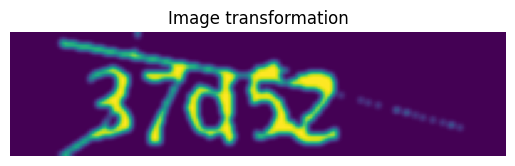

In [2]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import img_to_array
from PIL import Image
import imageio.v3 as imageio

# Initialize data arrays
X = []
y = []

# Kernel definitions for morphological operations
# I changed initial measure of close kernel from 5x5 to 3x3
close_kernel = np.ones((3, 3), np.uint8)
dilate_kernel = np.ones((2, 2), np.uint8)

# Process images from directory
for dirname, _, filenames in os.walk('/kaggle/input/lallulollipop/'):
    for filename in filenames:
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Process only image files
            path = os.path.join(dirname, filename)
            image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            
            # Read image using imageio in grayscale mode.
            # image = imageio.imread(path, mode='F')
            # # Convert image to uint8 if necessary (imageio may return floats in [0,1]).
            # if image.dtype != np.uint8:
            #     image = (image * 255).astype(np.uint8)
            
            if image is None:
                continue  # Skip if the image couldn't be loaded
            
            # Adaptive Threshold
            image = cv2.adaptiveThreshold(
                image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 2
            )
            
            # Morphological Closing
            image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, close_kernel)
            
            # Dilation
            image = cv2.dilate(image, dilate_kernel, iterations=2) # helpful to increase
            
            # Gaussian Blur
            image = cv2.GaussianBlur(image, (5, 5), 0)
            # TODO trying inversion here
            image = cv2.bitwise_not(image)
            # Ensure the segmented area indices are valid
            # Split image into character segments dynamically if necessary
            try:
                # Segmentation coordinates - these should adapt dynamically
                # char_segments = [
                #     image[10:50, 30:50],
                #     image[10:50, 50:70],
                #     image[10:50, 70:90],
                #     image[10:50, 90:110],
                #     image[10:50, 110:130]
                # ]
                char_segments = [
                    image[8:48, 30:50],
                    image[8:48, 50:70],
                    image[8:48, 70:90],
                    image[8:48, 90:110],
                    image[8:48, 110:130]
                ] 
                
                # Attempt at dynamic settings
                # n_chars = 5
                # height, width = image.shape
                # start_row = int(height * 0.5)  # Example: use 30%-70% of the image height
                # end_row = int(height * 0.5)
                # char_width = width // n_chars  # Equally split the image width into 5 parts
                # char_segments = [ image[start_row:end_row, i*char_width:(i+1)*char_width] for i in range(n_chars) ]
                
                # char_segments = [
                #     image[10:50, 30:55],
                #     image[10:50, 50:75],
                #     image[10:50, 70:95],
                #     image[10:50, 90:115],
                #     image[10:50, 110:135]
                # ]
                # char_segments = [
                #     image[10:50, 30:50],
                #     image[10:50, 52:72],
                #     image[10:50, 74:94],
                #     image[10:50, 96:116],
                #     image[10:50, 118:138]
                # ]
                
                # Only process if we have valid segments and they align with the expected number of categories
                if len(char_segments) == len(filename[-9:-4]):  # Ensure matching number
                    for i, segment in enumerate(char_segments):
                        # Ensure segmentation data isn't empty
                        if segment.size > 0:
                            X.append(img_to_array(Image.fromarray(segment)))
                            y.append(filename[-9:-4][i])  # Extract corresponding label
                else:
                    print(f"Skipping {filename} due to mismatch in expected characters.")
            except IndexError:
                print(f"Skipping {filename} due to invalid segmentation indexing.")
plt.imshow(image) 
plt.axis('off') 
plt.title("Image transformation") 
plt.show()

# Convert X and y to NumPy arrays
X = np.array(X, dtype=np.float32) / 255.0  # Normalize images to [0, 1]
y = np.array(y)

# Label encoding (numerical transformation of classes/targets)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-hot encode the labels
onehot_encoder = OneHotEncoder(sparse_output=False)
y_onehot = onehot_encoder.fit_transform(y_encoded.reshape(-1, 1))

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.4, random_state=49, stratify=y_onehot
)

# Print dataset shapes
print(f"Processed {len(X)} segments.")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

plt.imshow(image) 
plt.axis('off') 
plt.title("Image transformation") 
plt.show()


In [3]:
# Normalize feature data to the range [0, 1]
X = X.astype(np.float32) / 255.0

# Encode labels using LabelEncoder and OneHotEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder = LabelEncoder()
y_le = label_encoder.fit_transform(y)

onehot_encoder = OneHotEncoder(sparse_output=False)
y_ohe = onehot_encoder.fit_transform(y_le.reshape(-1, 1))

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_ohe, test_size=0.4, random_state=420, stratify=y_le
)
# random_state changed from 42 to even funnier number
# Extract row and column dimensions
row, col = X.shape[1], X.shape[2]
categories = y_ohe.shape[1]
print(f'One-hot encoded dimensions = {row, col, categories}')

One-hot encoded dimensions = (40, 20, 19)


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam # Flatten X_train and X_test to 1D arrays since we're not using CNN
from tensorflow.keras.callbacks import ModelCheckpoint
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten the image for Dense layers
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Define the improved Dense Model with added BatchNormalization layers
# iski mkc aur dense banayenge hum
# model = Sequential([
#     Dense(512, activation='relu', input_shape=(X_train_flat.shape[1],)),  # Increased neurons in the first layer
#     BatchNormalization(),
#     Dropout(0.4),  # Adjusted dropout rate
#     Dense(256, activation='relu'), # gonna adjust this
#     BatchNormalization(),
#     Dropout(0.3),
#     Dense(128, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.3),
#     Dense(y_train.shape[1], activation='softmax')  # Output layer with number of categories
# ])

model = Sequential([
    Dense(1024, input_shape=(X_train_flat.shape[1],)),
    LeakyReLU(alpha=0.15),  # Using LeakyReLU with a small negative slope
    BatchNormalization(),
    Dropout(0.5),

    Dense(512),
    LeakyReLU(alpha=0.15),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(256),
    LeakyReLU(alpha=0.15),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(128),
    LeakyReLU(alpha=0.15),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(y_train.shape[1], activation='softmax')  # Output layer with number of categories
])

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, PReLU
# from tensorflow.keras.initializers import Constant

# model = Sequential([
   
#     Dense(512, input_shape=(X_train_flat.shape[1],)),
#     PReLU(alpha_initializer=Constant(0.1)),
#     BatchNormalization(),
#     Dropout(0.4),
    
#     Dense(256),
#     PReLU(alpha_initializer=Constant(0.1)),
#     BatchNormalization(),
#     Dropout(0.3),
    
#     Dense(256),
#     PReLU(alpha_initializer=Constant(0.1)),
#     BatchNormalization(),
#     Dropout(0.3),
    
#     Dense(y_train.shape[1], activation='softmax')  # Output layer with number of categories
# ])


# Compile the model with a learning rate scheduler
optimizer = Adam(learning_rate=0.001)  # Learning rate delta 0.000

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Setup EarlyStopping 
# no ModelCheckpoint
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=25,  # Stop training if no improvement for 25 epochs
    restore_best_weights=True
)

checkpoint_callback = ModelCheckpoint (
    filepath='/kaggle/working/model_checkpoint.keras',
    # save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# model_checkpoint = ModelCheckpoint(
#     '/kaggle/working/best_model.keras',
#     monitor='val_loss',
#     save_best_only=True,
#     mode='min'
# )

# Train the model with callbacks
history = model.fit(
    X_train_flat,
    y_train,
    validation_split=0.2,  # Split part of the training set for validation
    epochs=100,            # Number of epochs to train
    batch_size=128,        # Increased batch size for stable gradient updates, trying more. Increasing this -> EarlyStopping patience +
    verbose=1,
    callbacks=[early_stopping, checkpoint_callback]
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_flat, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1024)                │         820,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 19)                  │           2,451 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,519,379 (5.80 MB)

 Trainable params: 1,515,539 (5.78 MB)

 Non-trainable params: 3,840 (15.00 KB)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.2071 - loss: 3.0168
Epoch 1: val_loss improved from inf to 2.93084, saving model to /kaggle/working/model_checkpoint.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 591ms/step - accuracy: 0.2124 - loss: 2.9899 - val_accuracy: 0.0498 - val_loss: 2.9308
Epoch 2/100
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5312 - loss: 1.5598
Epoch 2: val_loss improved from 2.93084 to 2.92555, saving model to /kaggle/working/model_checkpoint.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5435 - loss: 1.5478 - val_accuracy: 0.0756 - val_loss: 2.9256
Epoch 3/100
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6484 - loss: 1.4411
Epoch 3: val_loss did not improve from 2.92555
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6434 - loss: 1.2714 - val_accuracy: 0.0636 - val_loss: 2.9334
Epoch 4/100
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7188 - loss: 1.0779
Epoch 4: val_loss did not improve from 2.92555
19

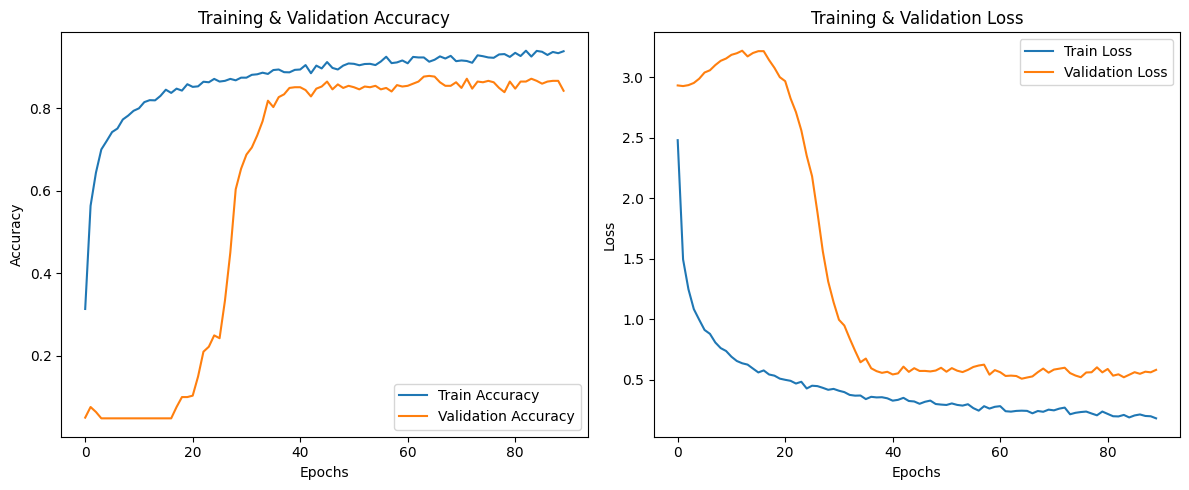

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


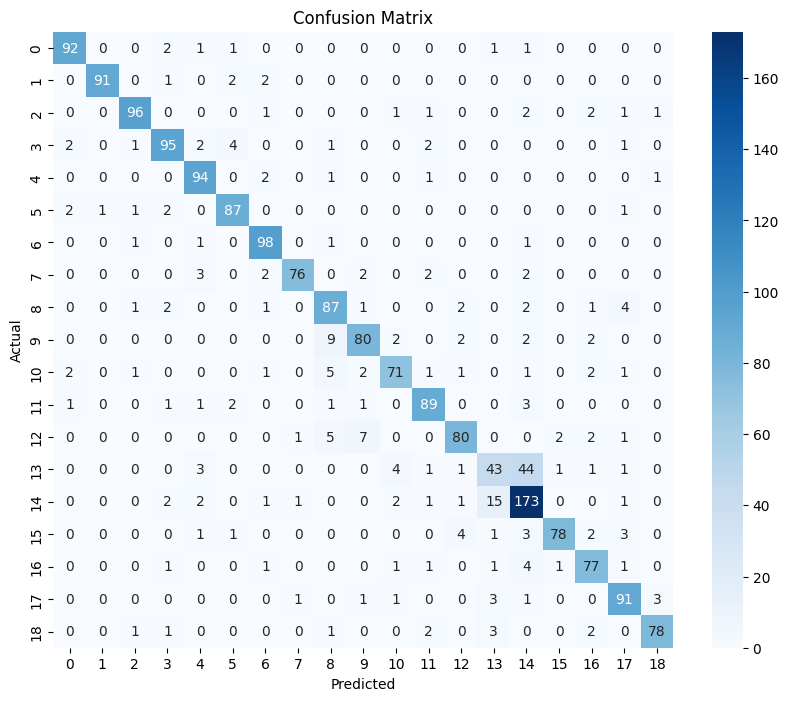

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plot training history (accuracy and loss over epochs)
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.tight_layout()
plt.show()

# Generate predictions on the test set
y_pred = model.predict(X_test_flat)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class indices
y_test_classes = np.argmax(y_test, axis=1)  # True test labels

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

# Set axis labels for the confusion matrix
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


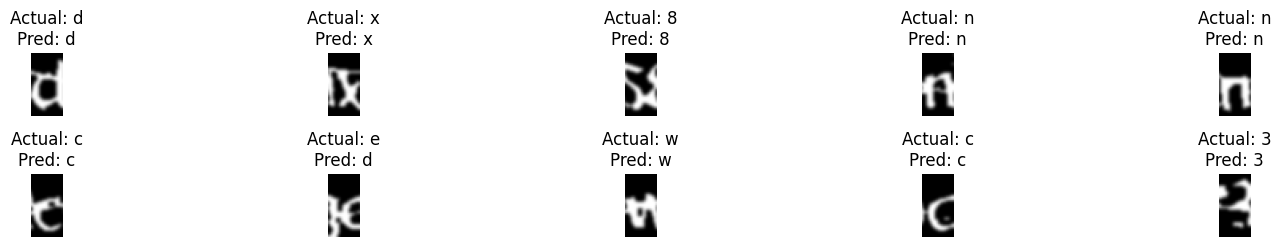

In [6]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Randomly sample a subset of data for evaluation
sample_size = 10  # Number of test samples you want to visualize
random_indices = random.sample(range(len(X_test_flat)), sample_size)

X_test_sampled = X_test_flat[random_indices]
y_test_sampled = y_test[random_indices]

# Make predictions
predictions = model.predict(X_test_sampled)

# Decode predictions
predicted_labels = np.argmax(predictions, axis=1)
actual_labels = np.argmax(y_test_sampled, axis=1)

# Visualize the predictions
image_height = X.shape[1]
image_width = X.shape[2]

plt.figure(figsize=(15, 5))
for i in range(sample_size):
    plt.subplot(4, 5, i + 1)  # 4 rows x 5 columns grid for visualization
    plt.imshow(X_test_sampled[i].reshape(image_height, image_width), cmap='gray')  # Reshape dynamically
    plt.title(f"Actual: {label_encoder.inverse_transform([actual_labels[i]])[0]}\nPred: {label_encoder.inverse_transform([predicted_labels[i]])[0]}")
    plt.axis('off')

plt.tight_layout()
plt.show()